# Digitizer Example

In [1]:
import os
import sys
srcpath = os.path.realpath('../SourceFiles')
sys.path.append(srcpath)
from teproteus import TEProteusAdmin as TepAdmin
from teproteus import TEProteusInst as TepInst

In [2]:
%matplotlib notebook
import numpy as np
import time
import ipywidgets as widgets
from IPython.core.debugger import set_trace
from scipy.signal import chirp, sweep_poly
import matplotlib.pyplot as plt

In [3]:
# Connect to instrument

admin = TepAdmin()
inst = admin.open_instrument(slot_id=4)

In [4]:
# Get the instrument's *IDN
resp = inst.send_scpi_query('*IDN?')
print(resp)

# Get the DAC mode (8 bits or 16 bits)
resp = inst.send_scpi_query(':SYST:INF:DAC?')
dac_mode = int(resp)
print('DAC {0} bits'.format(dac_mode))

if dac_mode == 16:
    max_dac = 65535
    data_type = np.uint16 
else:
    max_dac = 255
    data_type = np.uint8 
    
half_dac = max_dac / 2.0

Tabor Electronics,P9082M,000000220725,1.114.0
DAC 8 bits


## Dual-Channels Mode, Internal Trigger, 4 Frames of 4800 Samples

In [5]:
# Several initializations ..

inst.default_paranoia_level = 2

inst.send_scpi_cmd('*CLS; *RST')
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':FREQ:RAST 1.0e9')
inst.send_scpi_cmd(':INIT:CONT ON')
inst.send_scpi_cmd(':TRAC:DEL:ALL')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)


0, no error


In [6]:
# Build two AWG segment that will be used as innput for the digitizer

cycleLen = 1024
numCycles = 1
segLen = cycleLen * numCycles

# Build waveform (sine wave)
x = np.linspace(
    start=0, stop=2 * np.pi * numCycles, num=segLen, endpoint=False)

y = (np.sin(x) + 1.0) * half_dac
y = np.round(y)
y = np.clip(y, 0, max_dac)
y = y.astype(data_type)

# download it to segment 1 of channel 1
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':TRAC:DEF 1,' + str(segLen))
inst.send_scpi_cmd(':TRAC:SEL 1')

# download the waveform to the selected segment
inst.write_binary_data(':TRAC:DATA', y)

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

# Build waveform (triangle wave)
y = np.sin(x)
y = np.arcsin(y)* 2 * half_dac / np.pi + half_dac
y = np.round(y)
y = np.clip(y, 0, max_dac)
y = y.astype(data_type)

# download it to segment 2 of channel 2
inst.send_scpi_cmd(':INST:CHAN 2')
inst.send_scpi_cmd(':TRAC:DEF 2,' + str(segLen))
inst.send_scpi_cmd(':TRAC:SEL 2')


# download the waveform to the selected segment
inst.write_binary_data(':TRAC:DATA', y)

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

del x, y


0, no error
0, no error


In [7]:
# Play segment 1 in channel 1 of the AWG
# AWG Channl 1 (output) should be connected to Digitizer Channel 1 (input)
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':SOUR:FUNC:MODE:SEGM 1')
inst.send_scpi_cmd(':SOUR:VOLT 0.5')
inst.send_scpi_cmd(':OUTP ON')

# Play segment 2 in channel 2of the AWG
# AWG Channl 2 (output) should be connected to Digitizer Channel 2 (input)
inst.send_scpi_cmd(':INST:CHAN 2')
inst.send_scpi_cmd(':SOUR:FUNC:MODE:SEGM 2')
inst.send_scpi_cmd(':SOUR:VOLT 0.5')
inst.send_scpi_cmd(':OUTP ON')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)


0, no error


In [8]:
# Setup the digitizer in two-channels mode
inst.send_scpi_cmd(':DIG:MODE DUAL')
inst.send_scpi_cmd(':DIG:FREQ 800MHZ')

# Enable capturing data from channel 1
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')
inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')
# Select the internal-trigger as start-capturing trigger:
inst.send_scpi_cmd(':DIG:TRIG:SOURCE CPU')

# Enable capturing data from channel 2
inst.send_scpi_cmd(':DIG:CHAN:SEL 2')
inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')
# Select the internal-trigger as start-capturing trigger:
inst.send_scpi_cmd(':DIG:TRIG:SOURCE CPU')

# Allocate four frames of 4800 samples
numframes, framelen = 4, 4800
cmd = ':DIG:ACQuire:FRAM:DEF {0},{1}'.format(numframes, framelen)
inst.send_scpi_cmd(cmd)

# Select the frames for the capturing 
# (all the four frames in this example)
capture_first, capture_count = 1, numframes
cmd = ':DIG:ACQuire:FRAM:CAPT {0},{1}'.format(capture_first, capture_count)
inst.send_scpi_cmd(cmd)


resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)


0, no error


In [9]:
# Start the digitizer's capturing machine
inst.send_scpi_cmd(':DIG:INIT ON')

# Generate 4 software-triggers
for _ in range(capture_count):
    inst.send_scpi_cmd(':DIG:TRIG:IMM')
    time.sleep(0.1) # more than  enough for capturing single frame
    # Query the status
    resp = inst.send_scpi_query(':DIG:ACQuire:FRAM:STATus?')
    print(resp)

print()

# Stop the digitizer's capturing machine (to be on the safe side)
inst.send_scpi_cmd(':DIG:INIT OFF')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

1,0,0
1,0,0
1,0,0
1,1,0

0, no error


In [10]:
# Choose which frames to read (all in this example)
inst.send_scpi_cmd(':DIG:DATA:SEL ALL')

# Choose what to read 
# (only the frame-data without the header in this example)
inst.send_scpi_cmd(':DIG:DATA:TYPE FRAM')

# Get the total data size (in bytes)
resp = inst.send_scpi_query(':DIG:DATA:SIZE?')
num_bytes = np.uint32(resp)
print('Total size in bytes: ' + resp)
print()

# Read the data that was captured by channel 1:
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')

wavlen = num_bytes // 2

wav1 = np.zeros(wavlen, dtype=np.uint16)

rc = inst.read_binary_data(':DIG:DATA:READ?', wav1, num_bytes)

# Read the data that was captured by channel 2:
inst.send_scpi_cmd(':DIG:CHAN:SEL 2')

wav2 = np.zeros(wavlen, dtype=np.uint16)
rc = inst.read_binary_data(':DIG:DATA:READ?', wav2, num_bytes)

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

Total size in bytes: 38400

0, no error


<IPython.core.display.Javascript object>


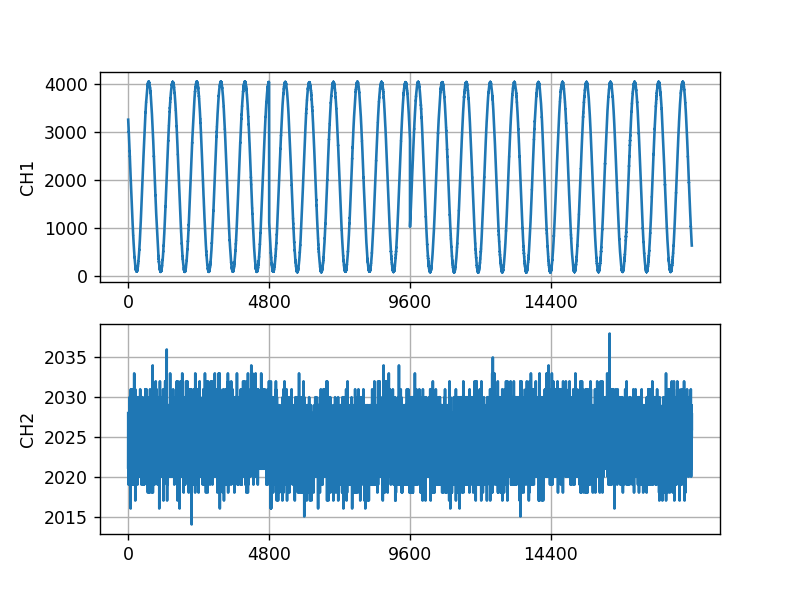

In [11]:
# Plot the samples
totlen = numframes * framelen
x = range(numframes * framelen)
plt.figure(1)
ax1 = plt.subplot(211)
ax1.set_xticks(np.arange(0, totlen, framelen))
ax1.grid(True)
ax1.plot(x, wav1)
ax1.set_ylabel('CH1')

ax2 = plt.subplot(212, sharex=ax1)
ax2.set_xticks(np.arange(0, totlen, framelen))
ax2.grid(True)
ax2.plot(x, wav2)
ax2.set_ylabel('CH2')

plt.show()

del wav1, wav2

## Single-Channel Mode, External-Trigger, 256 Frames of 24576 Samples

In [18]:
import tempfile
import os

# Create Temporary Directory for temporary wave-files

tempdir = tempfile.gettempdir()
#tempdirname = os.path.join(tempdirname, 'digexample')
tempdir = tempfile.mkdtemp(dir = tempdir)
print("tempdir: \'{0}\'".format(tempdir))

temp_name = next(tempfile._get_candidate_names())
wavfile1 = os.path.join(tempdir, temp_name + '.wav')
print("wavfile1: \'{0}\'".format(wavfile1))

tempdir: 'C:\Users\Nadav\AppData\Local\Temp\tmpysjq7xkr'
wavfile1: 'C:\Users\Nadav\AppData\Local\Temp\tmpysjq7xkr\_44pf0w2.wav'


In [19]:
# Several initializations ..
inst.send_scpi_cmd('*CLS; *RST')
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':FREQ:RAST 2.5e9')
inst.send_scpi_cmd(':INIT:CONT ON')
inst.send_scpi_cmd(':TRAC:DEL:ALL')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

0, no error


In [20]:
# Build AWG segment that will be used as innput for the digitizer

segLen = 48000

inst.send_scpi_cmd(':TRAC:DEF 1,' + str(segLen))
inst.send_scpi_cmd(':TRAC:SEL 1')

# just to make it interesting ..
p = np.poly1d([0.025, -0.36, 1.25, 2.0])
t = np.linspace(0, 10, segLen, endpoint=False)

y = sweep_poly(t, p)
del t
del p
y = np.round((y + 1.0) * half_dac)
y = np.clip(y, 0, max_dac)
y = y.astype(np.uint16)

inst.timeout = 30000
inst.write_binary_data(':TRAC:DATA', y)
inst.timeout = 10000

del y

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

# Play segment 1 in channel 1 of the AWG
# AWG Channl 1 (output) should be connected to Digitizer Channel 1 (input)
inst.send_scpi_cmd(":INST:CHAN 1")
inst.send_scpi_cmd(":SOUR:FUNC:MODE:SEGM 1")
inst.send_scpi_cmd(":SOUR:VOLT 0.5")
inst.send_scpi_cmd(":OUTP ON")

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)


0, no error
0, no error


In [21]:
# Setup the digitizer in single-channel mode
inst.send_scpi_cmd(':DIG:MODE SINGl')
inst.send_scpi_cmd(':DIG:FREQ 1.6GHZ')

# Select the external-trigger as start-capturing trigger:
inst.send_scpi_cmd(':DIG:CHAN:SEL 2')
inst.send_scpi_cmd(':DIG:TRIG:SOURCE EXT')

inst.send_scpi_cmd(':DIG:CHAN:SEL 1')
inst.send_scpi_cmd(':DIG:TRIG:SOURCE EXT')

# Select threshold level 1 of the external trigger
inst.send_scpi_cmd(':DIG:TRIG:LEV1 0.3')

# Enable capturing data from channel 1
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')
inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')


# Select the pattern of the external trigger
inst.send_scpi_cmd(":DIG:TRIG:TYPE EDGE")

# Allocate 256 frames of 24576 samples
numframes, framelen = 256, 24576
cmd = ":DIG:ACQuire:FRAM:DEF {0},{1}".format(numframes, framelen)
inst.send_scpi_cmd(cmd)

# Select the frames for the capturing 
# (all the four frames in this example)
capture_first, capture_count = 1, numframes
cmd = ":DIG:ACQuire:FRAM:CAPT {0},{1}".format(capture_first, capture_count)
inst.send_scpi_cmd(cmd)


resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)


0, no error


In [22]:
# Start the digitizer's capturing machine
inst.send_scpi_cmd(':DIG:INIT ON')

# Wait till capturing is completed 
# (assuming that some external signal generates the triggers)
for itrail in range(35):
    time.sleep(1)
    # Query the status
    resp = inst.send_scpi_query(':DIG:ACQuire:FRAM:STATus?')
    print('{0: >3}. {1}'.format(itrail + 1, resp))
    if resp == '1,1,0':
        break

print()

# Stop the digitizer's capturing machine (to be on the safe side)
inst.send_scpi_cmd(':DIG:INIT OFF')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

  1. 1,1,0

0, no error


In [23]:
# -----------------------------------------------------------------------------------
# Reading all frames at once might be inefficient  because of big memory allocations.
# -----------------------------------------------------------------------------------

if False:

    # Set reading mode of multiple frames
    inst.send_scpi_cmd(':DIG:DATA:SEL ALL')
    
    # Get the total data size (in bytes)
    resp = inst.send_scpi_query(':DIG:DATA:SIZE?')
    num_bytes = np.uint32(resp)
    print('Total size in bytes: ' + resp)
    
    wav_len = num_bytes // 2
    wav1 = np.zeros(wav_len, dtype=np.uint16)

    rc = inst.read_binary_data(':DIG:DATA:READ?', wav1, num_bytes)

    plt.figure()
    plt.plot(wav1)
    plt.show()
    del wav1

In [25]:
# -----------------------------------------------------------------------------------
# If there are a lot of short frames, then reading a single frame at a time 
# might be inefficient because of the overhead in each reading.
# The way to keep it efficient is to read N frames at a time,
# where the total length of the N frames is about 1:4 Mega samples
# -----------------------------------------------------------------------------------

# A chunk of 64 frames hold 1.5 Mega samples
frames_chunk = 64

inst.send_scpi_query(':DIG:CHAN:SEL 1')

# Set reading mode of multiple frames
inst.send_scpi_query(':DIG:DATA:SEL FRAM')
    
# Choose what to read 
# (only the frame-data without the header in this example)
inst.send_scpi_query(':DIG:DATA:TYPE FRAM')

# the frame data size in bytes
frame_data_size = framelen * 2

wavbuf = np.empty(framelen * frames_chunk, dtype=np.uint16)

# Read the frames in chunks of 64-frames and store the data in a temporary-file
with open(wavfile1, "wb") as outfile:
    offs = 0
    while offs < numframes:
        
        if offs + frames_chunk > numframes:
            frames_chunk = numframes - offs
            wavbuf = np.empty(framelen * frames_chunk, dtype=np.uint16)
        
        # Choose which frames to read
        cmd = 'DIG:DATA:FRAM {0},{1}'.format(offs + 1, frames_chunk)
        pyte.send_cmd(inst, cmd)
        
        print('Reading {0} frames (offset {1})'.format(frames_chunk, offs))
        
        num_bytes = frame_data_size * frames_chunk
        
        # Read chunk of frames
        rc = iinst.read_binary_data(':DIG:DATA:READ?', wavbuf, num_bytes)
        
        # Write to file
        wavbuf.tofile(outfile)
        
        offs = offs + frames_chunk

del wavbuf
resp, rc = inst.send_scpi_query(':SYST:ERR?')
print(resp)

Reading 64 frames (offset 0)
Reading 64 frames (offset 64)
Reading 64 frames (offset 128)
Reading 64 frames (offset 192)
0, no error


IntSlider(value=10000, description='Plot Length', max=6291456)

IntText(value=0)

IntSlider(value=0, description='Plot Offset', max=6291456)

IntText(value=0)

<IPython.core.display.Javascript object>


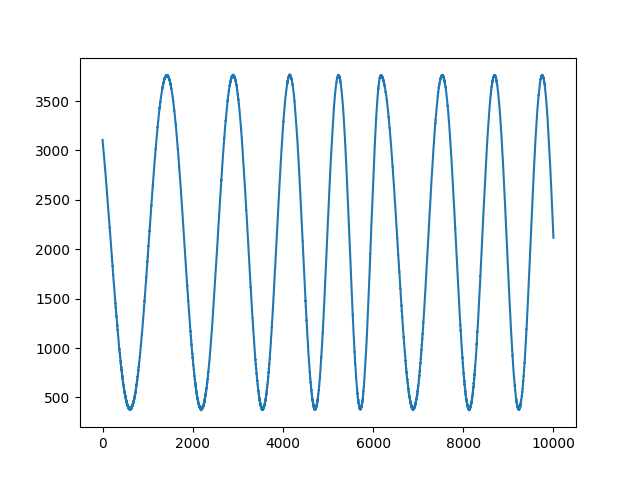

In [26]:
# Display the contents of the file (using interactive wigets)

wavlen1 = 0
try:
    wavdat = np.memmap(wavfile1, dtype=np.uint16, mode='r')
    wavlen1 = len(wavdat)
    del wavdat
except:
    wavlen1 = 0

plotlen1 = min(wavlen1, 10000)
plotoffs1 = 0

plotlen_slider1 = widgets.IntSlider(
    min=0, max=min(wavlen1, 10000000), value=min(wavlen1, 10000), description='Plot Length')

plotoffs_slider1 = widgets.IntSlider(min=0, max=wavlen1, value=0, description='Plot Offset')

plotlen_text1 = widgets.IntText()
plotlen_link1 = widgets.jslink((plotlen_slider1, 'value'), (plotlen_text1, 'value'))

plotoffs_text1 = widgets.IntText()
plotoffs_link1 = widgets.jslink((plotoffs_slider1, 'value'), (plotoffs_text1, 'value'))

def plot_wavdat1(offset, length):
    global wavfile1
    fig1 = plt.figure(3)
    ax = fig1.gca()
    ax.clear()
    try:
        wavdat = np.memmap(wavfile1, dtype=np.uint16, mode='r')
        ax.plot(range(offset, offset + length), wavdat[offset: offset + length])
        del wavdat
    except:
        pass
    plt.show()

def handle_plotlen_slider1_change(change):
    global plotoffs_slider1
    global wavlen1
    length = change.new
    offset = plotoffs_slider1.value
    if length + offset > wavlen1:
        length = min(length, wavlen1)
        offset = max(0, wavlen1 - length)
    plot_wavdat1(offset, length)
    
def handle_plotoffs_slider1_change(change):
    global plotlen_slider1
    global wavlen1
    length = plotlen_slider1.value
    offset = change.new
    if length + offset > wavlen1:
        offset = min(offset, wavlen1)
        length = max(0, wavlen1 - offset)
    plot_wavdat1(offset, length)

plotlen_slider1.observe(handle_plotlen_slider1_change, names='value')

plotoffs_slider1.observe(handle_plotoffs_slider1_change, names='value')

display(plotlen_slider1, plotlen_text1, plotoffs_slider1, plotoffs_text1)

plot_wavdat1(plotoffs_slider1.value, plotlen_slider1.value)
